In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

class TimeSeriesPredictor:
    def __init__(self, lookback_days=10, prediction_days=1):
        self.lookback_days = lookback_days
        self.prediction_days = prediction_days
        self.scaler = StandardScaler()
        self.model = None
        
    def create_sequences(self, df):
        """Create sequences for time series prediction"""
        X, y = [], []
        
        # Convert to numpy for faster processing
        data = df.values
        
        for i in range(len(df) - self.lookback_days - self.prediction_days + 1):
            # Get sequence of features
            sequence = data[i:(i + self.lookback_days)]
            # Flatten the sequence
            flat_sequence = sequence.reshape(1, -1)
            X.append(flat_sequence)
            
            # Get target
            target = data[i + self.lookback_days + self.prediction_days - 1][-1]
            y.append(target)
            
        return np.vstack(X), np.array(y)

    def prepare_data(self, df):
        """Prepare data for modeling"""
        # Scale features
        scaled_data = pd.DataFrame(
            self.scaler.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        
        # Create sequences
        X, y = self.create_sequences(scaled_data)
        return X, y
    
    def objective(self, trial, X_train, y_train, X_val, y_val):
        """Optuna objective for hyperparameter optimization"""
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 0.5)
        }
        
        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            early_stopping_rounds=50
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        preds = model.predict(X_val)
        return mean_squared_error(y_val, preds, squared=False)  # RMSE

    def train(self, df, n_trials=100):
        """Train the model with hyperparameter optimization"""
        # Prepare data
        X, y = self.prepare_data(df)
        
        # Create time series split
        tscv = TimeSeriesSplit(n_splits=5, test_size=len(X)//5)
        
        # Initialize best sc        # For each fold
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            print(f"\nOptimizing Fold {fold+1}/5...")
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: self.objective(trial, X_train, y_train, X_val, y_val),
                         n_trials=n_trials)
            
            print(f"Best parameters for fold {fold+1}: ", study.best_params)
            
            # Train model with best parameters
            model = xgb.XGBRegressor(**study.best_params, random_state=42)
            model.fit(X_train, y_train)
            
            # Evaluate
            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"Fold {fold+1} RMSE: {score:.4f}")
            
            if score < best_score:
                best_score = score
                best_model = model
        
        self.model = best_model
        return best_score
    
    def predict(self, df):
        """Make predictions"""
        X, _ = self.prepare_data(df)
        return self.model.predict(X)
    
    def evaluate(self, df, show_plots=True):
        """Evaluate model performance"""
        X, y = self.prepare_data(df)
        predictions = self.model.predict(X)
        
        # Calculate metrics
        rmse = mean_squared_error(y, predictions, squared=False)
        mae = mean_absolute_error(y, predictions)
        r2 = r2_score(y, predictions)
        
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2 Score: {r2:.4f}")
        
        if show_plots:
            # Plot actual vs predicted
            plt.figure(figsize=(12, 6))
            plt.scatter(y, predictions, alpha=0.5)
            plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('Actual vs Predicted Values')
            plt.show()
            
            # Plot feature importances
            importance_type = 'weight'  # can be 'weight', 'gain', or 'cover'
            feature_imp = pd.DataFrame({
                'feature': [f'sequence_{i}' for i in range(X.shape[1])],
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 6))
            plt.bar(range(20), feature_imp['importance'][:20])
            plt.xticks(range(20), feature_imp['feature'][:20], rotation=45)
            plt.title(f'Top 20 Feature Importances ({importance_type})')
            plt.tight_layout()
            plt.show()
            
            # Plot predictions vs actual over time
            plt.figure(figsize=(15, 6))
            plt.plot(df.index[-len(predictions):], y, label='Actual', alpha=0.7)
            plt.plot(df.index[-len(predictions):], predictions, label='Predicted', alpha=0.7)
            plt.title('Predictions vs Actual Over Time')
            plt.legend()
            plt.tight_layout()
            plt.show()


[I 2024-11-05 10:32:45,961] A new study created in memory with name: no-name-a44d952d-8865-454c-80fe-e895af334c9d


Training model...

Optimizing Fold 1/5...


[I 2024-11-05 10:32:46,348] Trial 0 finished with value: 0.997210390344865 and parameters: {'max_depth': 9, 'learning_rate': 0.04508129555775478, 'n_estimators': 604, 'min_child_weight': 4, 'subsample': 0.7864286497749318, 'colsample_bytree': 0.6580341415962202, 'gamma': 0.07522615273015376}. Best is trial 0 with value: 0.997210390344865.
[I 2024-11-05 10:32:46,653] Trial 1 finished with value: 0.997210390344865 and parameters: {'max_depth': 4, 'learning_rate': 0.02581442361210283, 'n_estimators': 457, 'min_child_weight': 7, 'subsample': 0.9073152943938999, 'colsample_bytree': 0.8079789372945014, 'gamma': 0.24831266253275897}. Best is trial 0 with value: 0.997210390344865.
[I 2024-11-05 10:32:46,944] Trial 2 finished with value: 0.997210390344865 and parameters: {'max_depth': 8, 'learning_rate': 0.09648771081641118, 'n_estimators': 190, 'min_child_weight': 1, 'subsample': 0.8149318643809622, 'colsample_bytree': 0.7386252310170757, 'gamma': 0.05046144989968604}. Best is trial 0 with val

Best parameters for fold 1:  {'max_depth': 9, 'learning_rate': 0.04508129555775478, 'n_estimators': 604, 'min_child_weight': 4, 'subsample': 0.7864286497749318, 'colsample_bytree': 0.6580341415962202, 'gamma': 0.07522615273015376}


[I 2024-11-05 10:33:00,348] A new study created in memory with name: no-name-eee464ac-0084-4ee6-84ae-24c6e6497b56


Fold 1 RMSE: 0.9972

Optimizing Fold 2/5...


[I 2024-11-05 10:33:08,384] Trial 0 finished with value: 0.8715131589882444 and parameters: {'max_depth': 5, 'learning_rate': 0.0640184106543848, 'n_estimators': 497, 'min_child_weight': 6, 'subsample': 0.8686663344744838, 'colsample_bytree': 0.7718300632890523, 'gamma': 0.02036342695716542}. Best is trial 0 with value: 0.8715131589882444.
[I 2024-11-05 10:33:20,866] Trial 1 finished with value: 0.864557934810676 and parameters: {'max_depth': 6, 'learning_rate': 0.024173951254542442, 'n_estimators': 176, 'min_child_weight': 4, 'subsample': 0.7684422999530196, 'colsample_bytree': 0.8616949883506734, 'gamma': 0.47918301176154465}. Best is trial 1 with value: 0.864557934810676.
[I 2024-11-05 10:33:30,312] Trial 2 finished with value: 0.8713345282685252 and parameters: {'max_depth': 9, 'learning_rate': 0.09516305187468894, 'n_estimators': 253, 'min_child_weight': 5, 'subsample': 0.8295130228502845, 'colsample_bytree': 0.9079315656531579, 'gamma': 0.13298104561598223}. Best is trial 1 with 

Best parameters for fold 2:  {'max_depth': 3, 'learning_rate': 0.0865506026493937, 'n_estimators': 481, 'min_child_weight': 7, 'subsample': 0.7626240778930631, 'colsample_bytree': 0.909372248235555, 'gamma': 0.4682435076895257}


[I 2024-11-05 10:38:42,038] A new study created in memory with name: no-name-90f4389b-8d04-4154-81a9-fbb2bd06c640


Fold 2 RMSE: 0.8329

Optimizing Fold 3/5...


[I 2024-11-05 10:38:47,393] Trial 0 finished with value: 0.634162751447905 and parameters: {'max_depth': 5, 'learning_rate': 0.09190767523802701, 'n_estimators': 137, 'min_child_weight': 7, 'subsample': 0.9762515185752767, 'colsample_bytree': 0.6727195951593573, 'gamma': 0.11386988758596894}. Best is trial 0 with value: 0.634162751447905.
[I 2024-11-05 10:39:05,384] Trial 1 finished with value: 0.6528957245450627 and parameters: {'max_depth': 7, 'learning_rate': 0.038566503011426806, 'n_estimators': 672, 'min_child_weight': 4, 'subsample': 0.8897644493553564, 'colsample_bytree': 0.8145817214637169, 'gamma': 0.40263380603806687}. Best is trial 0 with value: 0.634162751447905.
[I 2024-11-05 10:39:18,218] Trial 2 finished with value: 0.6493229655669626 and parameters: {'max_depth': 8, 'learning_rate': 0.08060896138618198, 'n_estimators': 241, 'min_child_weight': 7, 'subsample': 0.6035501055480834, 'colsample_bytree': 0.7545003246179154, 'gamma': 0.05881833312943102}. Best is trial 0 with 

Best parameters for fold 3:  {'max_depth': 3, 'learning_rate': 0.07670468932919691, 'n_estimators': 618, 'min_child_weight': 6, 'subsample': 0.8032870239522959, 'colsample_bytree': 0.8706222804396596, 'gamma': 0.06912616001820482}


[I 2024-11-05 10:48:23,828] A new study created in memory with name: no-name-ed305fc0-445f-4bea-a616-cf17a107e51d


Fold 3 RMSE: 0.6491

Optimizing Fold 4/5...


[I 2024-11-05 10:48:29,776] Trial 0 finished with value: 0.5436733674407349 and parameters: {'max_depth': 3, 'learning_rate': 0.052924622449830004, 'n_estimators': 316, 'min_child_weight': 5, 'subsample': 0.9281605242592983, 'colsample_bytree': 0.7665193562447195, 'gamma': 0.2623136722531335}. Best is trial 0 with value: 0.5436733674407349.
[I 2024-11-05 10:48:43,779] Trial 1 finished with value: 0.5499199949809735 and parameters: {'max_depth': 6, 'learning_rate': 0.07305309929284887, 'n_estimators': 757, 'min_child_weight': 2, 'subsample': 0.7258468617154563, 'colsample_bytree': 0.8246722649468222, 'gamma': 0.28161733626151675}. Best is trial 0 with value: 0.5436733674407349.
[I 2024-11-05 10:49:02,373] Trial 2 finished with value: 0.566796275189634 and parameters: {'max_depth': 10, 'learning_rate': 0.06676435875510225, 'n_estimators': 657, 'min_child_weight': 4, 'subsample': 0.692101100997374, 'colsample_bytree': 0.6629204266661185, 'gamma': 0.3353202936796344}. Best is trial 0 with 

Best parameters for fold 4:  {'max_depth': 3, 'learning_rate': 0.05489424867407469, 'n_estimators': 610, 'min_child_weight': 2, 'subsample': 0.9705773760017, 'colsample_bytree': 0.9657331117579868, 'gamma': 0.07250936791939556}


[I 2024-11-05 11:02:57,534] A new study created in memory with name: no-name-b7f2b554-670b-4ec0-ad44-032441a917d6


Fold 4 RMSE: 0.5372

Optimizing Fold 5/5...


[I 2024-11-05 11:03:19,350] Trial 0 finished with value: 0.7434032311243973 and parameters: {'max_depth': 9, 'learning_rate': 0.0779567819008462, 'n_estimators': 106, 'min_child_weight': 5, 'subsample': 0.9631449937727388, 'colsample_bytree': 0.8880118085263997, 'gamma': 0.13223520962964092}. Best is trial 0 with value: 0.7434032311243973.
[I 2024-11-05 11:03:33,338] Trial 1 finished with value: 0.7217438564283915 and parameters: {'max_depth': 3, 'learning_rate': 0.027045743591474103, 'n_estimators': 778, 'min_child_weight': 6, 'subsample': 0.9978817410469087, 'colsample_bytree': 0.856410684671735, 'gamma': 0.12819857842661697}. Best is trial 1 with value: 0.7217438564283915.
[I 2024-11-05 11:04:22,842] Trial 2 finished with value: 0.7278441373279234 and parameters: {'max_depth': 6, 'learning_rate': 0.015309700528849828, 'n_estimators': 457, 'min_child_weight': 5, 'subsample': 0.8715286298181948, 'colsample_bytree': 0.9254446080827314, 'gamma': 0.38850891913374863}. Best is trial 1 wit

Best parameters for fold 5:  {'max_depth': 4, 'learning_rate': 0.06886453974276428, 'n_estimators': 692, 'min_child_weight': 2, 'subsample': 0.6925577045106994, 'colsample_bytree': 0.9216283476458822, 'gamma': 0.0019654195974462274}
Fold 5 RMSE: 0.7251

Best validation RMSE: 0.5372

Test Set Performance:
RMSE: 0.6780
MAE: 0.4998
R2 Score: 0.5395


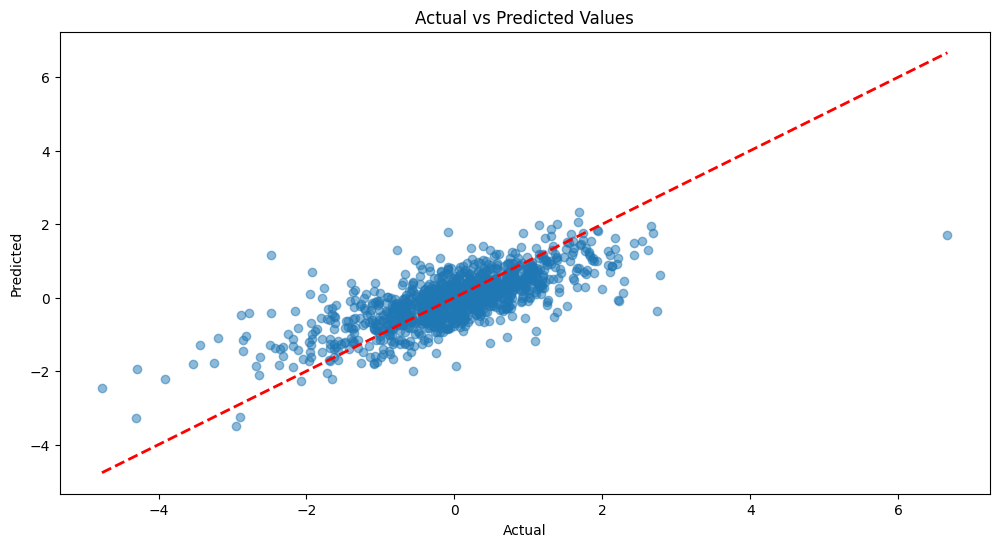

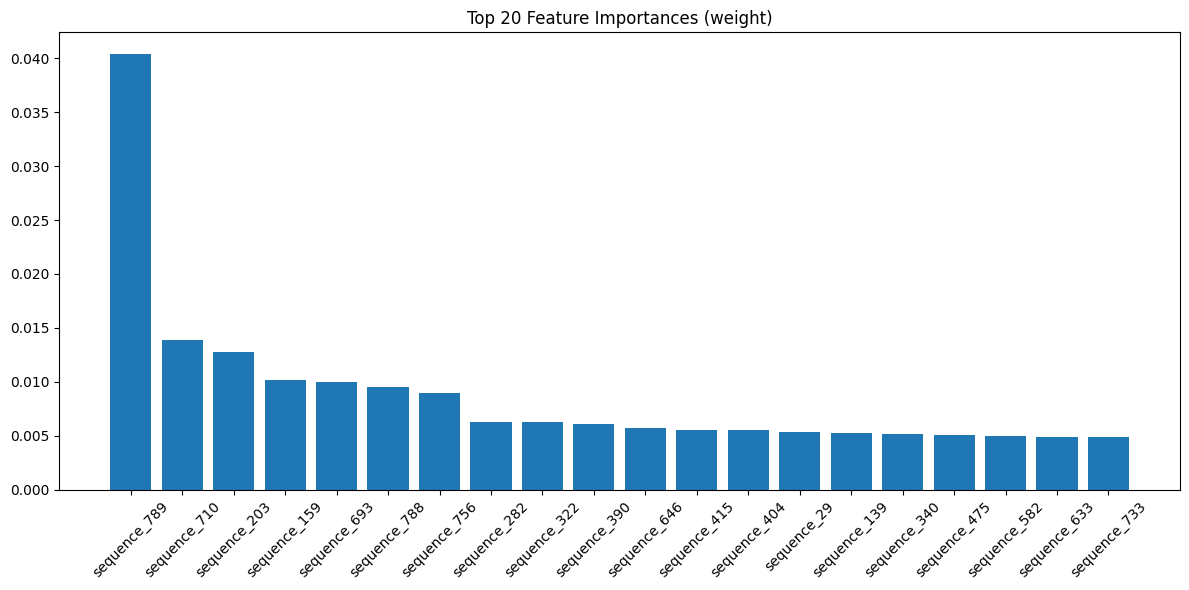

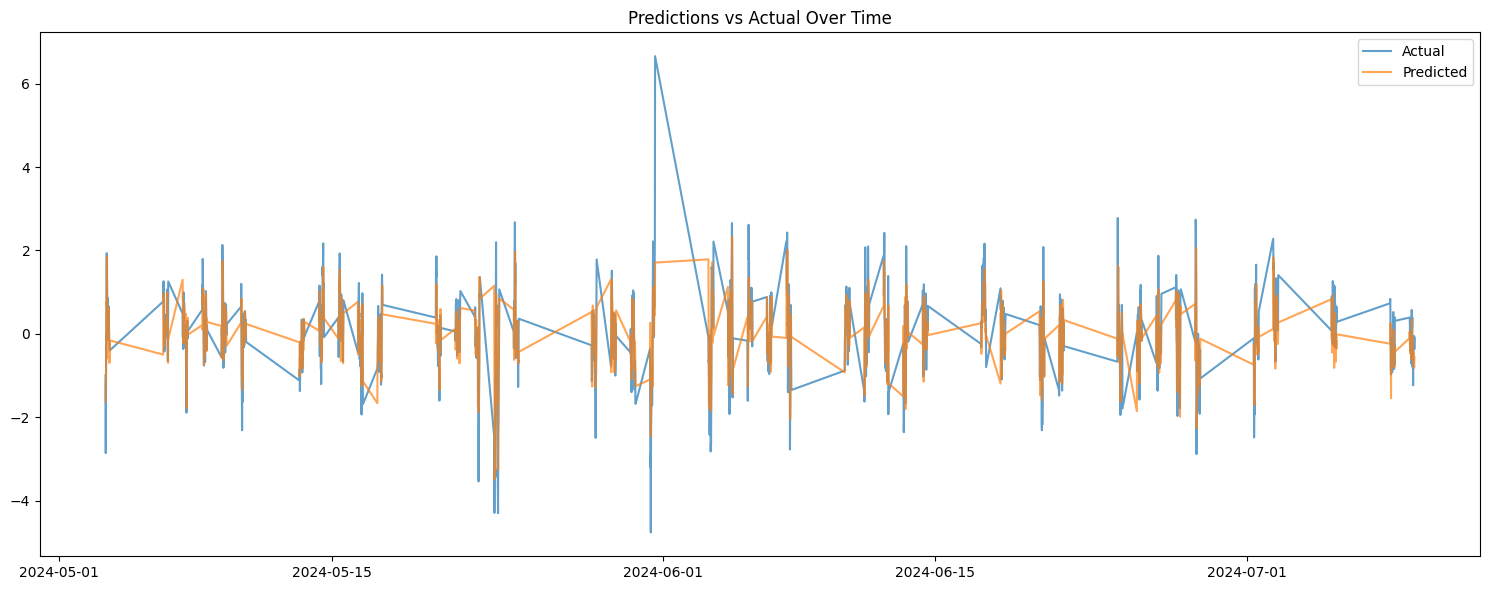

In [3]:
# Load data
df = pd.read_csv('model_data.csv', parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

# Initialize predictor
predictor = TimeSeriesPredictor(lookback_days=10, prediction_days=1)

# Split data into train and test
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print("Training model...")
best_score = predictor.train(train_df, n_trials=50)  # reduced trials for faster iteration
print(f"\nBest validation RMSE: {best_score:.4f}")

print("\nTest Set Performance:")
predictor.evaluate(test_df)